In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from scipy.io import loadmat


In [2]:
torch.tensor([1])

tensor([1])

In [3]:
pwd

'/mnt/pesaranlab/People/Capstone_students/Noah/Sleeping-Monkeys/notebooks'

In [4]:
cd ../../../Noah

/mnt/pesaranlab/People/Capstone_students/Noah


In [8]:
moving_files = os.listdir('data/move/')
sleeping_files = os.listdir('data/sleep')

In [37]:
moving_files[0].split('_')[1].split('_')[0]

'005'

In [133]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train' ,moving_files=moving_files,sleeping_files=sleeping_files):
        self.movement_files = moving_files
        self.sleeping_files = sleeping_files
        all_files = self.sleeping_files + self.movement_files
        if mode == 'train':
            self.all_files = [f for f in all_files if f.split('_')[0] not in ['180411','180412', '180413']]
        elif mode == 'valid':
            self.all_files = [f for f in all_files if f.split('_')[0] in ['180411','180412']]
        if mode == 'test':
            self.all_files = [f for f in all_files if '0328' in f]
            
        # clean
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
       # labe
       # spec = torch.from_numpy(np.load('data/'self.all_files[idx])).unsqueeze(0)
        mvmt_type  = self.all_files[idx].split('_')[-1].split('.')[0] #check this out
        date = self.all_files[idx].split('_')[0]
        rec = self.all_files[idx].split('_')[1].split('_')[0]
        spec = torch.from_numpy(np.load('data/'+ mvmt_type +'/' +self.all_files[idx])) 
        if mvmt_type == 'move':
            label = torch.Tensor([0])
        elif mvmt_type == 'sleep':
            label = torch.Tensor([1])
        else:
            label = torch.Tensor([-1])
        return  torch.transpose(spec,1,2) , label, date, rec

In [134]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')
test_dataset  = NoahSpectrogramDataset(mode='test')


In [135]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle = False)

In [136]:
for spec, label, date, rec in val_loader:
    
    spec
    break

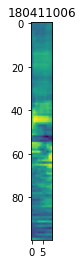

In [140]:
plt.title(date[0] + rec[0])
plt.imshow(spec[0][:].mean(axis=0))

In [44]:
# Recording 6 

spec = loadmat('../Spectrogram_mat_data/N10W1dn1_180411_rec006.mat')

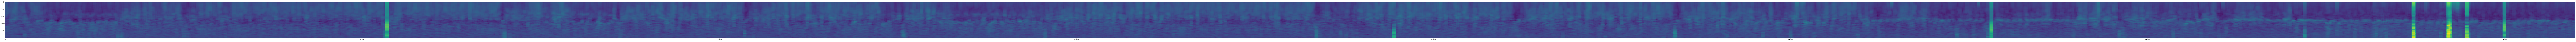

In [63]:
ch = 1
plt.figure(figsize = (250,100))
plt.imshow(spec['Spec_per_Ch']['Ch'+str(ch)][0][0]['ztotSpec'][0][0].T)

Loaded in 1 file from april, and it was bad

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout1 = nn.Dropout2d(.5)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(8*100*10, num_classes)
        self.dropout2 = nn.Dropout2d(.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.float()
        x = self.dropout1(relu(self.conv1(x)))
        x = self.dropout2(relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x
    
class LogReg(nn.Module):
    def __init__(self, input_dim=100*10, output_dim=1):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.resize(x.shape[0],1,10*100).float()
        outputs = torch.sigmoid(self.linear(x))
        return outputs
    
class MLP(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x)).flatten()
        x = self.sigmoid(x)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 10

model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [14]:
def get_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            predictions = []
            for o in outputs:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            correct += (predictions.flatten() == labels.flatten().numpy()).sum().item()
    return correct / total

In [15]:
def train(epoch):
    model.train()
    batch_losses = []
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
#             if epoch == 0:
#                 bad_data[batch_idx] = data
            continue
        
        preds = model(data)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
    epoch_loss = sum(batch_losses)/len(batch_losses)
    acc = get_accuracy(train_loader) 
    return epoch_loss,acc

def test(loader):
    model.eval()
    batch_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            preds = model(data)
            loss = criterion(preds, labels)
            
            batch_losses.append(loss)
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        
    acc = get_accuracy(loader)
    return epoch_loss,acc

In [16]:
epochs = []
training_losses = []
training_acc = []
val_losses = []
validation_acc = []
for epoch in range(num_epochs):
    avg_train_loss, train_acc = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_acc = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)

Train loss for epoch 0: 0.43002206087112427
Val loss for epoch 0: 0.5623630881309509
Train loss for epoch 1: 0.37126389145851135
Val loss for epoch 1: 0.48004448413848877
Train loss for epoch 2: 0.3535903990268707
Val loss for epoch 2: 0.5811789035797119
Train loss for epoch 3: 0.3480073809623718
Val loss for epoch 3: 0.5363171100616455
Train loss for epoch 4: 0.328165203332901
Val loss for epoch 4: 0.6430889368057251
Train loss for epoch 5: 0.3196205794811249
Val loss for epoch 5: 0.4364182651042938
Train loss for epoch 6: 0.32313570380210876
Val loss for epoch 6: 0.49656862020492554
Train loss for epoch 7: 0.31025591492652893
Val loss for epoch 7: 0.5209197402000427
Train loss for epoch 8: 0.3138890564441681
Val loss for epoch 8: 0.47314217686653137
Train loss for epoch 9: 0.3146974444389343
Val loss for epoch 9: 0.4061792194843292


In [146]:
plt.style.use('dark_background')


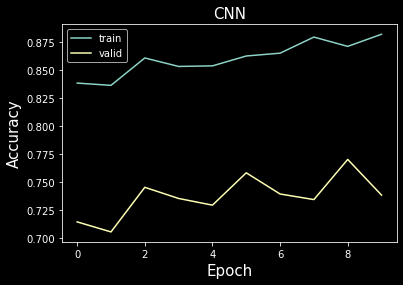

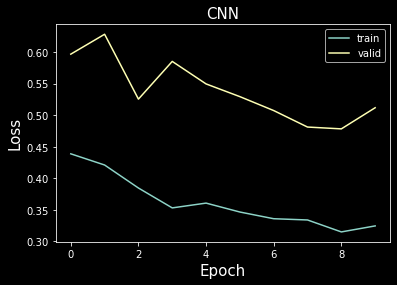

In [149]:
plt.figure()
plt.title("CNN", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(validation_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()

plt.figure()
plt.title("CNN", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()

In [8]:
model = MLP().to(device)

In [12]:
epochs = []
training_losses = []
training_acc = []
val_losses = []
validation_acc = []
for epoch in range(num_epochs):
    avg_train_loss, train_acc = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_acc = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)

Train loss for epoch 0: 0.6925397515296936


/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Val loss for epoch 0: 0.6933594346046448
Train loss for epoch 1: 0.6925438642501831
Val loss for epoch 1: 0.6933594346046448
Train loss for epoch 2: 0.6925637722015381
Val loss for epoch 2: 0.6933594346046448
Train loss for epoch 3: 0.6925548911094666
Val loss for epoch 3: 0.6933594346046448
Train loss for epoch 4: 0.6925438642501831
Val loss for epoch 4: 0.6933594346046448
Train loss for epoch 5: 0.6925179958343506
Val loss for epoch 5: 0.6933594346046448
Train loss for epoch 6: 0.6925466656684875
Val loss for epoch 6: 0.6933594346046448
Train loss for epoch 7: 0.6925514936447144
Val loss for epoch 7: 0.6933594346046448
Train loss for epoch 8: 0.6925720572471619
Val loss for epoch 8: 0.6933594346046448
Train loss for epoch 9: 0.6925402879714966
Val loss for epoch 9: 0.6933594346046448
